In [3]:
import pandas as pd

# データの読み込み
# ジムの利用履歴データ
DATASET_PATH = 'C://Users/toru/Work/dataset/31-40/'
path1 = DATASET_PATH + "use_log.csv"
path2 = "customer_join.csv"

uselog = pd.read_csv(path1)
customer = pd.read_csv(path2)

In [4]:
# 顧客データから必要なカラムを抽出
customer_clustering = customer[["mean", "median", "max", "min", "membership_period" ]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


### K-means法を使ったクラスタリング

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 標準化を実施
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# KMeans法を使用して４つのクラスに分類
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
# 「clusters列」クラスを各レコードに格納
customer_clustering["cluster"] = clusters.labels_

# ４つのクラスに分類されたことを確認
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[1 2 3 0]


<ipython-input-5-4a11c5c50477>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [6]:
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
# クラス毎に集計
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [7]:
# クラス毎に平均値を出力
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


#### 上記の出力からわかること
- 1は会員期間が短く、利用頻度が高い
- 3は会員期間が短く、利用頻度が低い

In [8]:
# クラスタリング結果の可視化

# 次元削除
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

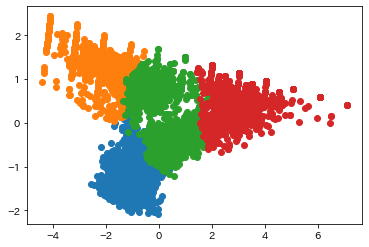

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

In [12]:
x_pca

array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [13]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [14]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [22]:
# 各顧客別に集計
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
uselog_months.head()
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [29]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

C:\Users\tooso\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [30]:
# 欠損値のあるデータを除去
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [31]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [35]:
# 会員期間の計算
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

from dateutil.relativedelta import relativedelta
predict_data["period"] = None

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years * 12 + delta.months
predict_data.head()

<ipython-input-35-00b6db913872>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years * 12 + delta.months


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [38]:
# 来月の利用予測回数モデルを作成

# 利用頻度が安定回数の顧客を除外
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]

from sklearn import linear_model
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]

# 利用頻度が安定回数の顧客を除外
import sklearn
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, Y_train)

LinearRegression()

In [40]:
# モデルのスコアを算出
print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.5990452048507271
0.6310048551147829


In [41]:
# 説明変数ごとの寄与している変数を確認
coef = pd.DataFrame({"feature_names": X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.329160
1,count_1,0.197205
2,count_2,0.174879
3,count_3,0.173277
4,count_4,0.073299
5,count_5,0.049425
6,period,0.051765


In [42]:
# 顧客データの予測
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]

x_pred = [x1, x2]
model.predict(x_pred)

array([3.78221484, 2.0213163 ])

In [43]:
uselog_months.to_csv("use_log_months.csv", index=False)